# # Accelerometer/Optical Flow data report

## Extract accelerometer and optical flow data

In [58]:
# Extract accelerometer data and optical flow data
# LucasKanade is a custom class
import pandas as pd
from LucasKanade import LK

acc_src = "Data/1/DCO_accel_COM5_2MHz_1.csv";
video_src = "C:/Users/Ala/Documents/GitHub/SenSync/Sync/MM/Python/Data/temp/1/1.avi";
video_timing_src = "C:/Users/Ala/Documents/GitHub/SenSync/Sync/MM/Python/Data/temp/1/timing.csv"

# Extract accelerometer csv
accel_columns = ['Timestamp', 'X', 'Y', 'Z'];
dco_df = pd.read_csv(acc_src, names=accel_columns);
dco = dco_df.as_matrix();

# Extract video timings
video_columns = ['Timestamp', 'Number'];
frame_df = pd.read_csv(acc_src, names=video_columns);
frame_timings = frame_df.as_matrix();

# Analyze video and grab optical flow (Y-axis)
lkanad = LK(video_src);
lkanad.run();

## High pass filter

In [59]:
from scipy import signal
# Quick define a high pass filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

freq = 8 #8 Hz for video, 50 Hz for acc
cutoff = 30;

## Plot accelerometer vs optical flow

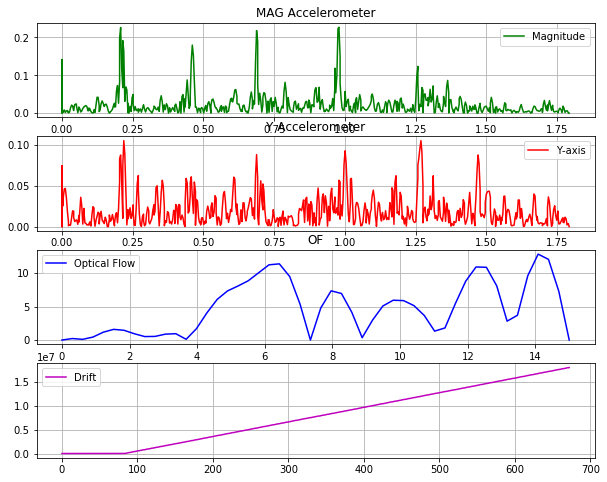

In [74]:
import numpy as np
import scipy.interpolate as interp
import matplotlib
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook();

# Set default plot size
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Accelerometer data
# Time
atime = dco[:,0];
atime = atime - atime[0];

# Magnitude
mag_dco = np.square(dco[:,1]) + np.square(dco[:,2]) + np.square(dco[:,3]);
mag_dco = np.sqrt(mag_dco);
afreq = 50;
acutoff=15;
mag_dco_filtered = butter_highpass_filter(mag_dco, acutoff, afreq);
mag_dco_filtered = abs(mag_dco_filtered);

# Y axis
y_dco = dco[:,2];
y_dco_filtered = butter_highpass_filter(y_dco, acutoff, afreq);
y_dco_filtered = abs(y_dco_filtered);

# Flow data
ffreq = 8;    # 8 FPS 
fcutoff = 3;  

flow = np.concatenate(np.asarray(lkanad.flow), axis=0);
x_flow = flow[:,0,0];
y_flow = flow[:,0,1];

frames = np.linspace(0, lkanad.frame_idx);

y_interp = interp.interp1d(np.arange(y_flow.size), y_flow);
y_compressed = y_interp(np.linspace(0, y_flow.size-1, frames.size));
y_compressed = y_compressed - y_compressed[0];
y_compressed_filtered = butter_highpass_filter(y_compressed, fcutoff, ffreq);
y_compressed_filtered = abs(y_compressed_filtered);


# Verify drift between accelerometer and optical flow sensor
vtimings = frame_timings[:,0] - frame_timings[0,0];

timing_interp = interp.interp1d(np.arange(vtimings.size), vtimings);

# Stretch it to match atime
frame_timings_solid = timing_interp(np.linspace(0, vtimings.size-1, atime.size));

drift = abs(frame_timings_solid - atime);
#drift = drift[70:];

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4);
ax1.plot(atime, mag_dco_filtered, 'g', label="Magnitude");
ax1.grid();
ax1.set_title("MAG Accelerometer")
ax1.legend();
ax2.plot(atime, y_dco_filtered, 'r', label="Y-axis");
ax2.grid();
ax2.set_title("Y Accelerometer");
ax2.legend();
ax3.plot(frames, y_compressed_filtered, 'b', label="Optical Flow");
ax3.grid();
ax3.set_title("OF");
ax3.legend();
ax4.plot(drift, 'm', label="Drift");
ax4.grid();
ax4.legend();
plt.show();



### Regarding Figure in 1.3
The graphs above correspond to 5 steps taken while wearing the data collection helmet. The optical flow data is in blue, the Y axis of the accelerometer is in red, and the magnitude of the accelerometer is in green. 

When looking at optical flow data, the movement of the Y axis away from the center is the most prevalent signal, as it captures the subtle head-bobbing when taking steps, which is also captured by the accelerometer. Further, the figure shows that the magnitude of the accelerometer data (green) is the clearest. 

It is also clear that there is a significant drift between the camera (16 MHz clock) and the accelerometer data (2 MHz clock) .

## Train Classifier for Step recognition and reconstruct events